In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, roc_curve, precision_score, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay

In [21]:
#Load dataset
dfi = pd.read_csv("data/train/invoice_train.csv")
dfc = pd.read_csv("data/train/client_train.csv")

/var/folders/zt/86rhwj4x2c71000f7qtwbh5c0000gn/T/ipykernel_2062/2932095438.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  dfi = pd.read_csv("data/train/invoice_train.csv")


In [27]:
dfi.drop('invoice_date', axis=1, inplace=True)

In [42]:
# we check the values for certain columns and decider, wether we transform them to categorical or not.
dfi.tarif_type= dfi.tarif_type.astype('category')
dfi.counter_type = dfi.counter_type.astype('category')
dfi.counter_code = dfi.counter_code.astype('category')
dfi.reading_remarque = dfi.reading_remarque.astype('category')

# some columns can be reduced to int8, to save memory.
dfi.counter_coefficient = dfi.counter_coefficient.astype('int8')
dfi.months_number = dfi.months_number.astype('int16')

dfi.consommation_level_4 = dfi.consommation_level_4.astype('int32')
dfi.consommation_level_3 = dfi.consommation_level_3.astype('int32')
dfi.consommation_level_2 = dfi.consommation_level_2.astype('int32')
dfi.consommation_level_1 = dfi.consommation_level_1.astype('int32')

# dfi.counter_statue.value_counts()
dfi.counter_statue = dfi.counter_statue.astype('category')

In [26]:

dfi.drop(dfi[dfi['months_number'] > 48].index, axis=0, inplace=True)
list_erroneous_month_clients = dfi.query("months_number > 48").client_id.tolist()
dfi = dfi[~dfi['client_id'].isin(list_erroneous_month_clients)]
dfc = dfc[~dfc['client_id'].isin(list_erroneous_month_clients)]



In [28]:
dfi.head(15)

,client_id,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC
5,train_Client_0,11,1335667,0,207,9,1,314,0,0,0,15638,15952,8,ELEC
6,train_Client_0,11,1335667,0,207,9,1,541,0,0,0,15952,16493,12,ELEC
7,train_Client_0,11,1335667,0,207,9,1,585,0,0,0,16493,17078,8,ELEC
8,train_Client_0,11,1335667,0,203,9,1,1200,186,0,0,7770,9156,4,ELEC
9,train_Client_0,11,1335667,0,203,6,1,1082,0,0,0,9156,10238,4,ELEC


First, we will try a naive decision tree.

We need to arrange the categorical and numerical variables

In [40]:
dfi

client_id               object
tarif_type               int64
counter_number           int64
counter_statue          object
counter_code             int64
reading_remarque         int64
counter_coefficient      int64
consommation_level_1     int64
consommation_level_2     int64
consommation_level_3     int64
consommation_level_4     int64
old_index                int64
new_index                int64
months_number            int64
counter_type            object
dtype: object

In [54]:
#Have to clean up the counter_statue column cause Decision tree gets upset converting the string to a float

#I'm wondering now if the 0s are actually all missing values, kinda

dfi.counter_statue.unique().tolist()
dfi.counter_statue.replace({'4' : 4, '5' : 5, '0' : 0, '1' : 1, 'A' : 6, 618 : 6, 420 : 6 }, inplace=True)

dfi.counter_type.replace({"ELEC":0,"GAZ":1}, inplace=True)

In [57]:
dfi.counter_statue.unique().tolist()

[0, 1, 5, 4, 3, 2, 6]

In [50]:
dfi.reading_remarque.value_counts()
dfi.reading_remarque.replace({413 : 7, 5 : 7}, inplace=True)

In [58]:
X = dfi.drop('client_id', axis=1)

list_of_targets = dfc.query('target == 1').client_id.tolist()
y = pd.Series(dfi.client_id.isin(list_of_targets))

In [59]:
#Split into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
#Because we have heavily imbalanced classes, we use stratify to ensure similar proportions of each class in the train and test splits

In [60]:
tree = DecisionTreeClassifier(random_state=42)

tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [61]:
y_pred = tree.predict(X_test)
y_probs = tree.predict_proba(X_test)

In [62]:
recall_score(y_test,y_pred)

0.6642445814818173

In [63]:
precision_score(y_test, y_pred)

0.6564239864675636

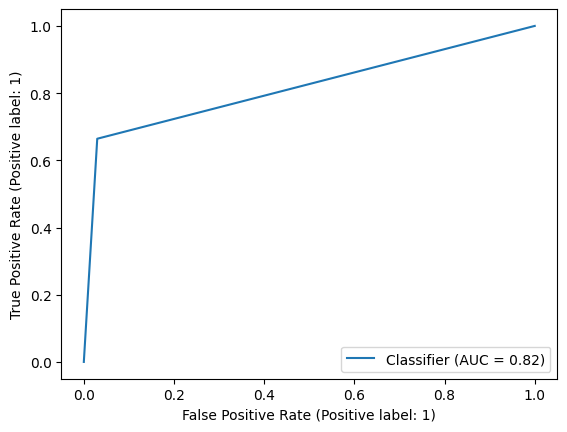

In [68]:
roc_curve(y_test, y_pred)
RocCurveDisplay.from_predictions(y_test,y_pred)

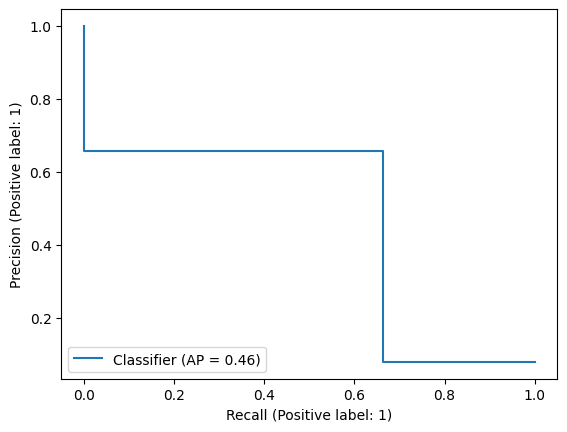

In [71]:
PrecisionRecallDisplay.from_predictions(y_test, y_pred)